# **Stock Prices Predictions with DeepAR**

This Notebook will contain the modeling phases needed to predict stock prices using a deep learning model.
The stocks analyzed will be the following:
* IBM
* AAPL (Apple Inc.)
* AMZN (Amazon Inc.)
* GOOGL (Alphabet Inc.)


In [272]:
import sagemaker

# Data preparation

Data must be prepared in order to be processed by DeepAR model:
* Train/test set split
* Save Data locally
* Upload to S3

In [273]:
data_dir = 'stock_deepar'

## Save Data Locally

In [274]:
import os

In [187]:
data_dir_csv = os.path.join(data_dir, 'csv') # The folder we will use for storing data
if not os.path.exists(data_dir_csv): # Make sure that the folder exists
    os.makedirs(data_dir_csv)

In [189]:
# IBM
df_ibm_train.to_csv(os.path.join(data_dir_csv, 'ibm_train.csv'), header=True, index=True)
df_ibm_test.to_csv(os.path.join(data_dir_csv, 'ibm_test.csv'), header=True, index=True)
df_ibm_valid.to_csv(os.path.join(data_dir_csv, 'ibm_valid.csv'), header=True, index=True)

In [215]:
# Apple Inc.
df_aapl_train.to_csv(os.path.join(data_dir_csv, 'aapl_train.csv'), header=True, index=True)
df_aapl_test.to_csv(os.path.join(data_dir_csv, 'aapl_test.csv'), header=True, index=True)
df_aapl_valid.to_csv(os.path.join(data_dir_csv, 'aapl_valid.csv'), header=True, index=True)

In [216]:
# Amazon.com
df_amzn_train.to_csv(os.path.join(data_dir_csv, 'amzn_train.csv'), header=True, index=True)
df_amzn_test.to_csv(os.path.join(data_dir_csv, 'amzn_test.csv'), header=True, index=True)
df_amzn_valid.to_csv(os.path.join(data_dir_csv, 'amzn_valid.csv'), header=True, index=True)

In [ ]:
# Alphabet Inc.
df_googl_train.to_csv(os.path.join(data_dir_csv, 'googl_train.csv'), header=True, index=True)
df_googl_test.to_csv(os.path.join(data_dir_csv, 'googl_test.csv'), header=True, index=True)
df_googl_valid.to_csv(os.path.join(data_dir_csv, 'googl_valid.csv'), header=True, index=True)

### JSON serialization

In order to feed DeepAR model, JSON files must be prepared from data.
I'll dispose two kind of JSON inputs:
* one with "dynamic features", to use a DeepAR API terminology: all dataset features except for target column and related one ('Adj Close', 'Close');
* one without "dynamic features: only 'Adj Close' column will be fed to DeepAR model.

#### DataFrame to JSON conversion

Now I'm going to convert data to JSON file format, in order to feed the DeepAR model correctly

As already announced, I will create two kind of time series, one with a list of dynamic features `dyn_feat`and the other one with only the target column (`Adj Close`) time series. 

In [275]:
# initializing train/test dataframe lists to iterate on them
dfs_train = [df_ibm_train, df_aapl_train, df_amzn_train, df_googl_train]
dfs_test = [df_ibm_test, df_aapl_test, df_amzn_test, df_googl_test]
dfs_valid = [df_ibm_valid, df_aapl_valid, df_amzn_valid, df_googl_valid]

Creating local storage path:

In [276]:
data_dir_json = os.path.join(data_dir, 'json')
if not os.path.exists(data_dir_json): # Make sure that the folder exists
    os.makedirs(data_dir_json)

Serializing data to json files

In [277]:
from source_deepar.deepar_utils import ts2DeepARjson_serialize

Dataset with the `Adj Close` time series alone:

Training data:

In [306]:
data_dir_json_train = os.path.join(data_dir_json, 'train') # The folder we will use for storing data
if not os.path.exists(data_dir_json_train): # Make sure that the folder exists
    os.makedirs(data_dir_json_train)

In [307]:
for df, m in zip(dfs_train, mnemonics):
    ts2DeepARjson_serialize(df, data_dir_json_train, m+'.json')

Test data:

In [308]:
data_dir_json_test = os.path.join(data_dir_json, 'test') # The folder we will use for storing data
if not os.path.exists(data_dir_json_test): # Make sure that the folder exists
    os.makedirs(data_dir_json_test)

In [309]:
for df, m in zip(dfs_test, mnemonics):
    ts2DeepARjson_serialize(df, data_dir_json_test, m+'.json')

Validation data:

In [310]:
data_dir_json_valid = os.path.join(data_dir_json, 'validation') # The folder we will use for storing data
if not os.path.exists(data_dir_json_valid): # Make sure that the folder exists
    os.makedirs(data_dir_json_valid)

In [311]:
for df, m in zip(dfs_valid, mnemonics):
    ts2DeepARjson_serialize(df, data_dir_json_valid, m+'.json')

Dataset containing dynamic features:

Training data:

In [312]:
data_dir_json_dyn_feat = os.path.join(data_dir_json, 'w_dyn_feat')

In [313]:
data_dir_json_train_dyn_feat = os.path.join(data_dir_json_dyn_feat, 'train') # The folder we will use for storing data
if not os.path.exists(data_dir_json_train_dyn_feat): # Make sure that the folder exists
    os.makedirs(data_dir_json_train_dyn_feat)

In [314]:
for df, m in zip(dfs_train, mnemonics):
    ts2DeepARjson_serialize(df, data_dir_json_train_dyn_feat, m+'.json', dyn_feat=['Open', '20_ac_bb_l', '20_ac_ma', '20_ac_bb_u'])

Test data:

In [315]:
data_dir_json_test_dyn_feat = os.path.join(data_dir_json_dyn_feat, 'test') # The folder we will use for storing data
if not os.path.exists(data_dir_json_test_dyn_feat): # Make sure that the folder exists
    os.makedirs(data_dir_json_test_dyn_feat)

In [316]:
for df, m in zip(dfs_test, mnemonics):
    ts2DeepARjson_serialize(df, data_dir_json_test_dyn_feat, m+'.json', dyn_feat=['Open',  '20_ac_bb_l', '20_ac_ma', '20_ac_bb_u'])

Validation data:

In [317]:
data_dir_json_valid_dyn_feat = os.path.join(data_dir_json_dyn_feat, 'validation') # The folder we will use for storing data
if not os.path.exists(data_dir_json_valid_dyn_feat): # Make sure that the folder exists
    os.makedirs(data_dir_json_valid_dyn_feat)

In [318]:
for df, m in zip(dfs_valid, mnemonics):
    ts2DeepARjson_serialize(df, data_dir_json_valid_dyn_feat, m+'.json', dyn_feat=['Open', '20_ac_bb_l', '20_ac_ma', '20_ac_bb_u'])

## AWS declarations

Defining training data Location

In [278]:
# Define IAM role and session
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()

In [279]:
interval ='D'

In [280]:
#Define training data location
s3_data_key = 'stock_deepar/train_artifacts'
s3_bucket = sagemaker_session.default_bucket()
s3_output_path = "s3://{}/{}/{}/output".format(s3_bucket, s3_data_key, interval)

In [281]:
#Obtain container image URI for SageMaker-DeepAR algorithm, based on region
region = sagemaker_session.boto_region_name
image_name = sagemaker.image_uris.retrieve("forecasting-deepar", region)
print("Model image : {}".format(image_name))

Model image : 495149712605.dkr.ecr.eu-central-1.amazonaws.com/forecasting-deepar:1


## Upload data to S3

Training input preparation

In [282]:
# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(data_dir_json, 'train')
test_prefix    = '{}/{}'.format(data_dir_json, 'test')
train_prefix_dyn_feat   = '{}/{}'.format(data_dir_json_dyn_feat, 'train')
test_prefix_dyn_feat    = '{}/{}'.format(data_dir_json_dyn_feat, 'test')

In [249]:
input_data_train = sagemaker_session.upload_data(path=data_dir_json_train, bucket=s3_bucket, key_prefix=train_prefix)

In [250]:
input_data_test = sagemaker_session.upload_data(path=data_dir_json_test, bucket=s3_bucket, key_prefix=test_prefix)

In [251]:
input_data_train_dyn_feat = sagemaker_session.upload_data(path=data_dir_json_train, bucket=s3_bucket, key_prefix=train_prefix_dyn_feat)

In [252]:
input_data_test_dyn_feat = sagemaker_session.upload_data(path=data_dir_json_test, bucket=s3_bucket, key_prefix=test_prefix_dyn_feat)

### Set DeepAR specific hyperparameters

In [323]:
from source_deepar import deepar_utils

In [283]:
# setting target columns
target_column = 'Adj Close'

In [325]:
# DeepAR estimator parameters    
hyperparameters = {
    "prediction_length": str(prediction_length[1]), #number of time-steps model is trained to predict, always generates forecasts with this length
    "context_length": str(context_length[1]), #number of time-points that the model gets to see before making the prediction, should be about same as the prediction_length
    "time_freq": interval, #granularity of the time series in the dataset
    "epochs": "200", #maximum number of passes over the training data
    "early_stopping_patience": "40", #training stops when no progress is made within the specified number of epochs
    "num_layers": "2", #number of hidden layers in the RNN, typically range from 1 to 4    
    "num_cells": "40", #number of cells to use in each hidden layer of the RNN, typically range from 30 to 100
    "mini_batch_size": "128", #size of mini-batches used during training, typically values range from 32 to 512
    "learning_rate": "1e-3", #learning rate used in training. Typical values range from 1e-4 to 1e-1
    "dropout_rate": "0.1", # dropout rate to use for regularization, typically less than 0.2. 
    "likelihood": "gaussian" #noise model used for uncertainty estimates - gaussian/beta/negative-binomial/student-T/deterministic-L1
}

## Estimator Instantiation

In [200]:
from sagemaker.estimator import Estimator

# instantiate a DeepAR estimator
estimator = Estimator(image_uri=image_name,
                      sagemaker_session=sagemaker_session,
                      #image_name=image_name,
                      role=role,
                      instance_count=1,
                      instance_type='ml.c4.xlarge',
                      output_path=s3_output_path,
                      hyperparameters=hyperparameters
                      )

## Training Job Creation

Creation of a training job with stand alone time series (no dynamic features provided). Run only if no model has already been trained before.

In [ ]:
%%time
# train and test channels
data_channels = {
    "train": input_data_train,
    "test": input_data_test
}

# fit the estimator
estimator.fit(inputs=data_channels)

## Existing Model Instantiation

Instatiation of a model from existing training artifacts (run only if a model has already been trained before).

In [326]:
model = sagemaker.model.Model(
    model_data='{}/{}/model.tar.gz'.format(s3_output_path, 'forecasting-deepar-2021-03-07-20-20-06-397/output'),
    image_uri= image_name,
    #image=image_name,  # example path for the semantic segmentation in eu-west-1
    role=role)  # your role here; could be different name

#trainedmodel.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge')

## Deploy and Create a Predictor

Now that we have trained a model, we can use it to perform predictions by deploying it to a predictor endpoint.

Remember to **delete the endpoint** at the end of this notebook. A cell at the very bottom of this notebook will be provided, but it is always good to keep, front-of-mind.

In [284]:
endpoint_name = 'DeepAR-ml-spp'

In [328]:
# create a predictor

from sagemaker.predictor import json_serializer, json_deserializer

In [329]:
# run it once, then update the endpoint if needed
%time

endpoint = model.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    endpoint_name=endpoint_name,
    serializer=json_serializer,
    deserializer=json_deserializer
)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
-------------------------!

update endpoint if needed:

In [ ]:
%time

# update an endpoint

predictor = estimator.update_endpoint(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
)

In [285]:
from source_deepar.deepar_utils import DeepARPredictor

In [286]:
json_predictor = DeepARPredictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker_session)
json_predictor.set_prediction_parameters(interval, prediction_length[1])

# Generating Predictions

According to the [inference format](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-in-formats.html) for DeepAR, the `predictor` expects to see input data in a JSON format, with the following keys:
* **instances**: A list of JSON-formatted time series that should be forecast by the model.
* **configuration** (optional): A dictionary of configuration information for the type of response desired by the request.

Within configuration the following keys can be configured:
* **num_samples**: An integer specifying the number of samples that the model generates when making a probabilistic prediction.
* **output_types**: A list specifying the type of response. We'll ask for **quantiles**, which look at the list of num_samples generated by the model, and generate [quantile estimates](https://en.wikipedia.org/wiki/Quantile) for each time point based on these values.
* **quantiles**: A list that specified which quantiles estimates are generated and returned in the response.


Below is an example of what a JSON query to a DeepAR model endpoint might look like.

```
{
 "instances": [
  { "start": "2009-11-01 00:00:00", "target": [4.0, 10.0, 50.0, 100.0, 113.0] },
  { "start": "1999-01-30", "target": [2.0, 1.0] }
 ],
 "configuration": {
  "num_samples": 50,
  "output_types": ["quantiles"],
  "quantiles": ["0.5", "0.9"]
 }
}
```

## Get Predictions

We can now use the model to get a predictions for input time series.

### Predicting IBM stock price

Ground truth:

In [287]:
test_gt = df_ibm_test.iloc[-prediction_length[1]:]['Adj Close']

In [288]:
# get all input and target (test) time series
# input_ts = [df_ibm_train, df_aapl_train, df_amzn_train, df_googl_train]
# target_ts = [df_ibm_test, df_aapl_test, df_amzn_test, df_googl_test]

input_ts = [df_ibm_train]
target_ts = [df_ibm]

# get the prediction from the predictor
json_prediction = json_predictor.predict(input_ts)

In [289]:
json_prediction[0]

,0.1,0.5,0.9
2021-01-16,122.329124,126.520729,130.485336
2021-01-17,121.412064,126.216721,129.881027
2021-01-18,121.762238,125.681206,129.608963
2021-01-19,122.315704,126.117393,130.657455
2021-01-20,121.127037,125.684715,129.578201
2021-01-21,120.072731,125.664032,130.467270
2021-01-22,120.713814,124.849754,131.629150
2021-01-23,120.183647,125.659798,131.816101
2021-01-24,119.925903,125.747345,130.881378
2021-01-25,119.555496,125.668053,131.482315


As we can see, index are just progressing of one day each row, wich is not stock price progression scheme in real life (e.g.: weekends are not trading days), so I'm going fix the index before going on with the analysis of results:

In [290]:
single_prediction = json_prediction[0]

In [291]:
single_prediction.index = test_gt.index

Save data locally:

In [292]:
data_dir_json_prediction = os.path.join(data_dir_json, 'prediction') # The folder we will use for storing data
if not os.path.exists(data_dir_json_prediction): # Make sure that the folder exists
    os.makedirs(data_dir_json_prediction)

In [293]:
start_date = str(single_prediction.index[0].date())
end_date = str(single_prediction.index[-1].date())

Prediction serialization:

In [294]:
single_prediction.to_json(os.path.join(data_dir_json_prediction, "IBM_{} - {}.json".format(start_date, end_date)),
                          orient='columns',date_format='iso')

Prediction de-serialization:

In [295]:
d_single_prediction = pd.read_json(os.path.join(data_dir_json_prediction, "IBM_{} - {}.json".format(start_date, end_date)),
                                   orient='columns', convert_axes=False)

Again, index normalization using target index, before using deserialized data:

In [296]:
d_single_prediction.index = test_gt.index

## Predicting the Future

Now we can try to feed our model with the validation dataset start date and compare its results to the benchmark model performances.

### Predicting IBM stock price

Ground truth:

In [301]:
test_gt = df_ibm_valid.iloc[-prediction_length[1]:]['Adj Close']

In [302]:
# get all input and target (test) time series
# input_ts = [df_ibm_train, df_aapl_train, df_amzn_train, df_googl_train]
# target_ts = [df_ibm_test, df_aapl_test, df_amzn_test, df_googl_test]

input_ts = [df_ibm_valid]
target_ts = [df_ibm_valid]

# get the prediction from the predictor
json_prediction = json_predictor.predict(input_ts)

In [303]:
json_prediction[0]

,0.1,0.5,0.9
2021-03-17,126.739998,135.554230,145.624359
2021-03-18,122.547256,133.238358,141.050903
2021-03-19,119.799263,130.239212,141.879410
2021-03-20,122.060638,131.740021,142.351730
2021-03-21,121.388618,133.816330,146.451492
2021-03-22,120.476959,134.400421,148.428024
2021-03-23,120.591553,134.480972,148.860260
2021-03-24,121.983368,135.359344,149.635803
2021-03-25,126.834808,138.104980,155.591690
2021-03-26,123.139008,136.199051,150.520355


As we can see, index are just progressing of one day each row, wich is not stock price progression scheme in real life (e.g.: weekends are not trading days), so I'm going fix the index before going on with the analysis of results:

In [304]:
single_prediction = json_prediction[0]

In [305]:
single_prediction.index = test_gt.index

In [306]:
single_prediction

,0.1,0.5,0.9
Date,,,
2021-02-17,126.739998,135.554230,145.624359
2021-02-18,122.547256,133.238358,141.050903
2021-02-19,119.799263,130.239212,141.879410
2021-02-22,122.060638,131.740021,142.351730
2021-02-23,121.388618,133.816330,146.451492
2021-02-24,120.476959,134.400421,148.428024
2021-02-25,120.591553,134.480972,148.860260
2021-02-26,121.983368,135.359344,149.635803
2021-03-01,126.834808,138.104980,155.591690


Save data locally:

In [307]:
data_dir_json_prediction = os.path.join(data_dir_json, 'prediction') # The folder we will use for storing data
if not os.path.exists(data_dir_json_prediction): # Make sure that the folder exists
    os.makedirs(data_dir_json_prediction)

In [308]:
start_date = str(single_prediction.index[0].date())
end_date = str(single_prediction.index[-1].date())

Prediction serialization:

In [309]:
single_prediction.to_json(os.path.join(data_dir_json_prediction, "IBM_{} - {}_valid.json".format(start_date, end_date)),
                          orient='columns',date_format='iso')

Prediction de-serialization:

In [310]:
d_single_prediction = pd.read_json(os.path.join(data_dir_json_prediction, "IBM_{} - {}_valid.json".format(start_date, end_date)),
                                   orient='columns', convert_axes=False)

Again, index normalization using target index, before using deserialized data:

In [356]:
d_single_prediction.index = test_gt.index

## Metrics computation

Now that we have predictions on validation dataset, we can compute our metrics and compare it to benchmakr model performaces.

### IBM Stock prices

Mean Absolute Error

In [312]:
ibm_dar_mae_loss = mean_absolute_error(test_gt, json_prediction[0]['0.5'])

In [313]:
print(ibm_dar_mae_loss)

12.477314758293282


Root Mean Squared Error

In [314]:
ibm_dar_mse_loss = mean_squared_error(test_gt, json_prediction[0]['0.5'], squared=False)

In [315]:
print(ibm_dar_mse_loss)

12.905939737319235


Mean Absolute Percentage Error

In [316]:
ibm_dar_map_loss = mean_absolute_percentage_error(test_gt, json_prediction[0]['0.5'])

In [317]:
print(ibm_dar_map_loss)

0.10201860418489066


R<sup>2</sup> score

In [318]:
ibm_dar_r2_score = r2_score(test_gt, json_prediction[0]['0.5'])

In [319]:
print(ibm_dar_r2_score)

-15.36958705453564


## Display the Results

The quantile data will give us all we need to see the results of our prediction.
* Quantiles 0.1 and 0.9 represent higher and lower bounds for the predicted values.
* Quantile 0.5 represents the median of all sample predictions.

In [363]:
# display the prediction median against the actual data
def display_quantiles(prediction, prediction_length, target_ts=None):
    """ show predictions for input time series """ 
    plt.figure(figsize=(12,6))
    # get the target month of data
    if target_ts is not None:
        #target = target_ts[:]
        #plt.plot(range(len(target)), target, label='target')
        target_ts.plot()
    # get the quantile values at 10 and 90%
    p10 = prediction['0.1']
    p90 = prediction['0.9']
    # fill the 80% confidence interval
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    # plot the median prediction line
    prediction['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

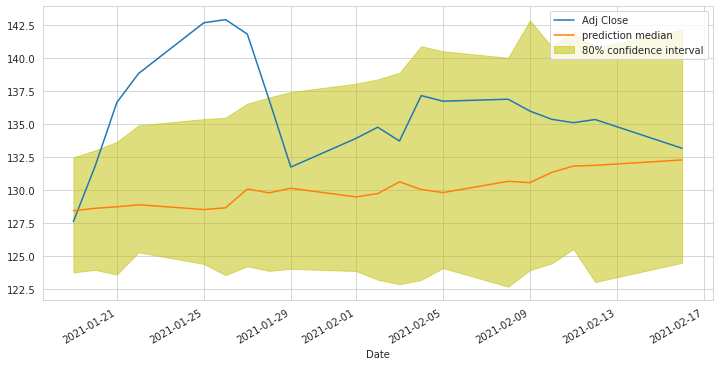

In [364]:
# display predictions
display_quantiles(d_single_prediction, prediction_length[1], test_gt)

### Predicting Apple stock price

Ground truth:

In [322]:
test_gt = df_aapl_test.iloc[-prediction_length[1]:]['Adj Close']

In [323]:
# get all input and target (test) time series
# input_ts = [df_ibm_train, df_aapl_train, df_amzn_train, df_googl_train]
# target_ts = [df_ibm_test, df_aapl_test, df_amzn_test, df_googl_test]

input_ts = [df_aapl_train]
target_ts = [df_aapl]

# get the prediction from the predictor
json_prediction = json_predictor.predict(input_ts)

In [324]:
json_prediction[0]

,0.1,0.5,0.9
2021-01-16,123.776581,128.459686,132.495636
2021-01-17,123.968361,128.639374,133.033813
2021-01-18,123.612305,128.752777,133.673264
2021-01-19,125.300209,128.906921,134.926483
2021-01-20,124.418503,128.546829,135.402847
2021-01-21,123.575371,128.673569,135.509171
2021-01-22,124.246483,130.104065,136.574722
2021-01-23,123.890968,129.810944,137.041565
2021-01-24,124.046646,130.156052,137.454422
2021-01-25,123.881447,129.502884,138.088181


As we can see, index are just progressing of one day each row, wich is not stock price progression scheme in real life (e.g.: weekends are not trading days), so I'm going fix the index before going on with the analysis of results:

In [325]:
single_prediction = json_prediction[0]

In [326]:
single_prediction.index = test_gt.index

Save data locally:

In [327]:
data_dir_json_prediction = os.path.join(data_dir_json, 'prediction') # The folder we will use for storing data
if not os.path.exists(data_dir_json_prediction): # Make sure that the folder exists
    os.makedirs(data_dir_json_prediction)

In [328]:
start_date = str(single_prediction.index[0].date())
end_date = str(single_prediction.index[-1].date())

Prediction serialization:

In [329]:
single_prediction.to_json(os.path.join(data_dir_json_prediction, "AAPL_{} - {}.json".format(start_date, end_date)),
                          orient='columns',date_format='iso')

Prediction de-serialization:

In [330]:
d_single_prediction = pd.read_json(os.path.join(data_dir_json_prediction, "AAPL_{} - {}.json".format(start_date, end_date)),
                                   orient='columns', convert_axes=False)

Simplifying date string

In [331]:
d_single_prediction.index = d_single_prediction.index

Again, index normalization using target index, before using deserialized data:

In [332]:
d_single_prediction.index = test_gt.index

#### Metrics computation

Mean Absolute Error

In [333]:
aapl_dar_mae_loss = mean_absolute_error(test_gt, json_prediction[0]['0.5'])

In [334]:
print(aapl_dar_mae_loss)

6.034310150153436


Root Mean Squared Error

In [335]:
aapl_dar_mse_loss = mean_squared_error(test_gt, json_prediction[0]['0.5'], squared=False)

In [336]:
print(aapl_dar_mse_loss)

7.1722294161925495


Mean Absolute Percentage Error

In [337]:
aapl_dar_map_loss = mean_absolute_percentage_error(test_gt, json_prediction[0]['0.5'])

In [338]:
print(aapl_dar_map_loss)

0.0436977659660809


R<sup>2</sup> score

In [339]:
aapl_dar_r2_score = r2_score(test_gt, json_prediction[0]['0.5'])

In [340]:
print(aapl_dar_r2_score)

-2.880691132009699


## Display the Results

The quantile data will give us all we need to see the results of our prediction.
* Quantiles 0.1 and 0.9 represent higher and lower bounds for the predicted values.
* Quantile 0.5 represents the median of all sample predictions.

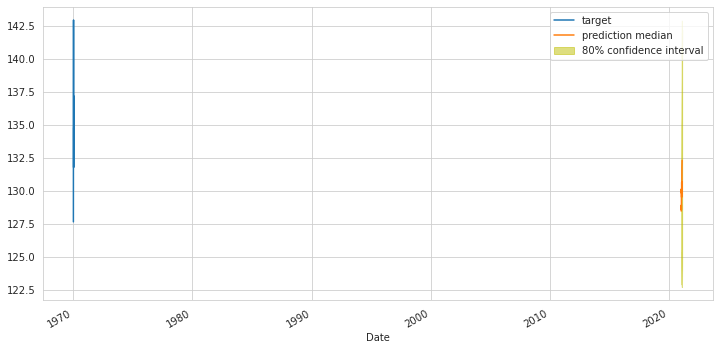

In [341]:
# display predictions
display_quantiles(d_single_prediction, prediction_length[1], test_gt)

### Predicting Amazon stock price

Ground truth:

In [419]:
test_gt = df_amzn_test.iloc[-prediction_length[1]:]['Adj Close']

In [422]:
# get all input and target (test) time series
# input_ts = [df_ibm_train, df_aapl_train, df_amzn_train, df_googl_train]
# target_ts = [df_ibm_test, df_aapl_test, df_amzn_test, df_googl_test]

input_ts = [df_amzn_train]
target_ts = [df_amzn]

# get the prediction from the predictor
json_prediction = json_predictor.predict(input_ts)

In [423]:
json_prediction[0]

,0.1,0.9,0.5
2021-01-14,3084.554932,3245.418213,3167.569824
2021-01-15,3088.180908,3256.072510,3177.134521
2021-01-16,3080.199219,3288.118896,3182.061768
2021-01-17,3094.484863,3291.157227,3212.899658
2021-01-18,3064.995605,3310.007324,3208.468750
2021-01-19,3074.138672,3329.010254,3220.762207
2021-01-20,3091.926758,3308.124756,3211.905273
2021-01-21,3080.706543,3315.033691,3213.785645
2021-01-22,3095.735107,3353.044434,3242.382324
2021-01-23,3116.385986,3378.254883,3233.464600


As we can see, index are just progressing of one day each row, wich is not stock price progression scheme in real life (e.g.: weekends are not trading days), so I'm going fix the index before going on with the analysis of results:

In [424]:
single_prediction = json_prediction[0]

In [425]:
single_prediction.index = test_gt.index

Save data locally:

In [426]:
data_dir_json_prediction = os.path.join(data_dir_json, 'prediction') # The folder we will use for storing data
if not os.path.exists(data_dir_json_prediction): # Make sure that the folder exists
    os.makedirs(data_dir_json_prediction)

In [427]:
start_date = str(single_prediction.index[0].date())
end_date = str(single_prediction.index[-1].date())

Prediction serialization:

In [428]:
single_prediction.to_json(os.path.join(data_dir_json_prediction, "AMZN_{} - {}.json".format(start_date, end_date)),
                          orient='columns',date_format='iso')

Prediction de-serialization:

In [429]:
d_single_prediction = pd.read_json(os.path.join(data_dir_json_prediction, "AMZN_{} - {}.json".format(start_date, end_date)),
                                   orient='columns', convert_axes=False)

Again, index normalization using target index, before using deserialized data:

In [431]:
d_single_prediction.index = test_gt.index

#### Metrics computation

Mean Absolute Error

In [432]:
amzn_dar_mae_loss = mean_absolute_error(test_gt, json_prediction[0]['0.5'])

In [433]:
print(amzn_dar_mae_loss)

67.96068115236376


Root Mean Squared Error

In [434]:
amzn_dar_mse_loss = mean_squared_error(test_gt, json_prediction[0]['0.5'], squared=False)

In [435]:
print(amzn_dar_mse_loss)

77.30706864366309


Mean Absolute Percentage Error

In [438]:
amzn_dar_map_loss = mean_absolute_percentage_error(test_gt, json_prediction[0]['0.5'])

In [439]:
print(amzn_dar_map_loss)

0.020645287504262862


R<sup>2</sup> score

In [440]:
amzn_dar_r2_score = r2_score(test_gt, json_prediction[0]['0.5'])

In [441]:
print(amzn_dar_r2_score)

-0.028067039566319174


## Display the Results

The quantile data will give us all we need to see the results of our prediction.
* Quantiles 0.1 and 0.9 represent higher and lower bounds for the predicted values.
* Quantile 0.5 represents the median of all sample predictions.

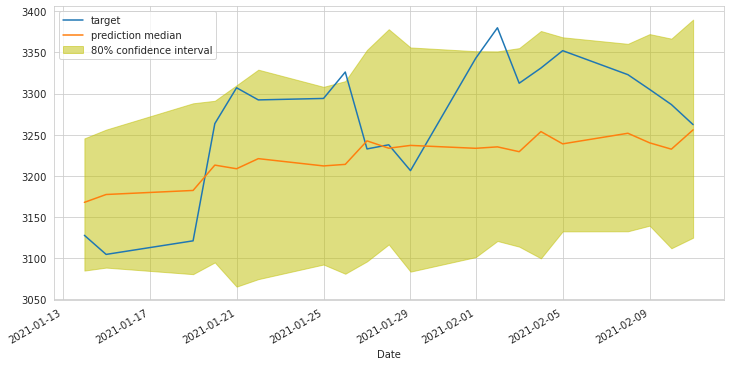

In [442]:
# display predictions
display_quantiles(d_single_prediction, prediction_length[1], test_gt)

### Predicting Alphabet stock price

Ground truth:

In [443]:
test_gt = df_googl_test.iloc[-prediction_length[1]:]['Adj Close']

In [444]:
# get all input and target (test) time series
# input_ts = [df_ibm_train, df_aapl_train, df_amzn_train, df_googl_train]
# target_ts = [df_ibm_test, df_aapl_test, df_amzn_test, df_googl_test]

input_ts = [df_googl_train]
target_ts = [df_googl]

# get the prediction from the predictor
json_prediction = json_predictor.predict(input_ts)

In [445]:
json_prediction[0]

,0.1,0.9,0.5
2021-01-14,1708.512451,1801.604614,1756.981445
2021-01-15,1703.664307,1798.472534,1756.093506
2021-01-16,1693.272827,1786.846191,1745.579834
2021-01-17,1674.004150,1786.466431,1736.667969
2021-01-18,1684.743286,1787.399292,1741.112671
2021-01-19,1682.821411,1808.798218,1747.433838
2021-01-20,1684.948120,1813.729492,1745.894165
2021-01-21,1685.006592,1806.732788,1747.387939
2021-01-22,1697.543335,1815.604736,1758.992432
2021-01-23,1693.155151,1830.079712,1763.710449


As we can see, index are just progressing of one day each row, wich is not stock price progression scheme in real life (e.g.: weekends are not trading days), so I'm going fix the index before going on with the analysis of results:

In [446]:
single_prediction = json_prediction[0]

In [447]:
single_prediction.index = test_gt.index

Save data locally:

In [448]:
data_dir_json_prediction = os.path.join(data_dir_json, 'prediction') # The folder we will use for storing data
if not os.path.exists(data_dir_json_prediction): # Make sure that the folder exists
    os.makedirs(data_dir_json_prediction)

In [449]:
start_date = str(single_prediction.index[0].date())
end_date = str(single_prediction.index[-1].date())

Prediction serialization:

In [450]:
single_prediction.to_json(os.path.join(data_dir_json_prediction, "GOOGL_{} - {}.json".format(start_date, end_date)),
                          orient='columns',date_format='iso')

Prediction de-serialization:

In [451]:
d_single_prediction = pd.read_json(os.path.join(data_dir_json_prediction, "GOOGL_{} - {}.json".format(start_date, end_date)),
                                   orient='columns', convert_axes=False)

Again, index normalization using target index, before using deserialized data:

In [453]:
d_single_prediction.index = test_gt.index

#### Metrics computation

Mean Absolute Error

In [454]:
googl_dar_mae_loss = mean_absolute_error(test_gt, json_prediction[0]['0.5'])

In [455]:
print(googl_dar_mae_loss)

170.9874572753956


Root Mean Squared Error

In [456]:
googl_ma_mse_loss = mean_squared_error(test_gt, json_prediction[0]['0.5'], squared=False)

In [457]:
print(googl_ma_mse_loss)

199.21410416670855


Mean Absolute Percentage Error

In [459]:
googl_dar_map_loss = mean_absolute_percentage_error(test_gt, json_prediction[0]['0.5'])

In [460]:
print(googl_dar_map_loss)

0.08576295206230264


R<sup>2</sup> score

In [463]:
googl_dar_r2_score = r2_score(test_gt, json_prediction[0]['0.5'])

In [464]:
print(googl_dar_r2_score)

-1.7231062485924302


## Display the Results

The quantile data will give us all we need to see the results of our prediction.
* Quantiles 0.1 and 0.9 represent higher and lower bounds for the predicted values.
* Quantile 0.5 represents the median of all sample predictions.

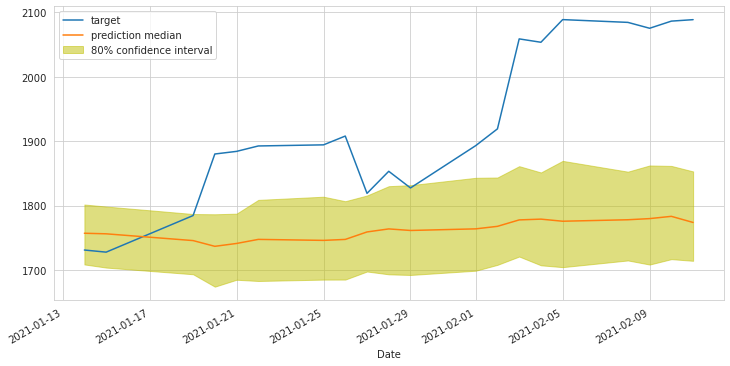

In [465]:
# display predictions
display_quantiles(d_single_prediction, prediction_length[1], test_gt)

## Predicting the Future -  validation data predictions

Now that we've tested our estimator on test set, we would like to see how it behaves on new data.
So we'll feed it with validation data we set apart before starting the training phase.

## Delete the Endpoint

Try your code out on different time series. You may want to tweak your DeepAR hyperparameters and see if you can improve the performance of this predictor.

When you're done with evaluating the predictor (any predictor), make sure to delete the endpoint.

In [ ]:
## TODO: delete the endpoint
json_predictor.delete_endpoint()